In [1]:
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage, signal, spatial

import os
import pandas as pd

from skimage import morphology, graph, segmentation
import skfmm

import gudhi as gd

In [2]:
def pers2numpy(pers):
    bd = np.zeros((len(pers), 3), dtype=float)
    for i in range(len(bd)):
        bd[i, 0] = pers[i][0]
        bd[i, 1:] = pers[i][1]
    return bd

def compute_cubical_homology(filename, inv, gdt, gimg, main):
    cc = gd.CubicalComplex(top_dimensional_cells = inv)
    pers = cc.persistence(homology_coeff_field=2, min_persistence=10)
    cof = cc.cofaces_of_persistence_pairs()
    print(len(cof), len(cof[0]), len(cof[0][0]))
    print(len(cof), len(cof[0]), len(cof[0][1]))
    print(len(cof), len(cof[1]), len(cof[1][0]))

    bd = pers2numpy(pers)
    bd = np.atleast_2d(bd[np.all(bd < np.inf, axis=1), :]).squeeze()
    bd0 = bd[bd[:,0] == 0, 1:]
    bd0 = np.vstack(([0,np.max(gdt)], bd0))
    bd0 = bd0[np.argsort(bd0[:,1])[::-1]]
    lt = bd0[:,1] - bd0[:,0]
    
    foo = np.argsort(main[cof[0][0][:,1]])[::-1]
    rest = np.vstack(([cof[1][0][0], gdt.shape[0]*int(ndimage.center_of_mass(gimg[0])[0])], cof[0][0][foo]))
    tips = np.column_stack((rest[:,0]%gdt.shape[0], rest[:,0]//gdt.shape[0]))
    merge = np.column_stack((rest[:,1]%gdt.shape[0], rest[:,1]//gdt.shape[0]))
    print(np.sum(main[rest] != bd0))
    
    birthdeath = pd.DataFrame(bd0, columns=['birth','death'])
    birthdeath['lifetime'] = lt
    birthdeath = pd.concat((birthdeath, pd.DataFrame(rest, columns=['tipF','endF'])), axis=1)
    birthdeath = pd.concat((birthdeath, pd.DataFrame(tips, columns=['tipX','tipY'])), axis=1)
    birthdeath = pd.concat((birthdeath, pd.DataFrame(merge, columns=['endX','endY'])), axis=1)
    geodesic = np.zeros(len(birthdeath))
    for i in range(len(geodesic)):
        geodesic[i] = gdt[tuple(tips[i])]
    birthdeath['root_geodesic'] = geodesic
    birthdeath.to_csv(filename, index=False)

    return 0

In [126]:
genotypes = ['CAL','MLB','222','299','517','521']
runnum = 2
src = '../run{:02d}/processed/'.format(runnum)

gdst = '../run{:02d}/gudhi/'.format(runnum)
ddst = '../run{:02d}/diagnostic/'.format(runnum)
if not os.path.isdir(gdst):
    os.mkdir(gdst)


gidx = 4
bfiles = sorted(glob(src + '*{}*.npy'.format(genotypes[gidx])))
print('Total number of files:\t{}\n'.format(len(bfiles)))
for i in range(len(bfiles)):
    print(i, bfiles[i], sep='\t')

Total number of files:	8

0	../run02/processed/1-517-1-M227_-_completed_binary_1365_3191_0_5706.npy
1	../run02/processed/1-517-2-F244_-_completed_binary_1332_3940_0_4401.npy
2	../run02/processed/3-517-1-F-1325_-_completed_binary_1403_3425_0_3699.npy
3	../run02/processed/3-517-2-M-1289_-_completed_binary_1126_4270_0_4833.npy
4	../run02/processed/4-517-1-M-1-378_-_completed_binary_1396_3852_0_4814.npy
5	../run02/processed/4-517-2-F-1-384_-_completed_binary_1410_3201_0_4233.npy
6	../run02/processed/5-517-1-M-1-007_-_completed_binary_635_3371_0_4324.npy
7	../run02/processed/5-517-2-F-1-075_-_completed_binary_1011_3964_0_5421.npy


In [127]:
idx = 0
bname = os.path.splitext(os.path.split(bfiles[idx])[1])[0].split('_-_')[0]
print(bfiles[idx], bname, sep='\n')
gimg = np.load(bfiles[idx], allow_pickle=True)

../run02/processed/1-517-1-M227_-_completed_binary_1365_3191_0_5706.npy
1-517-1-M227


# Compute the Geodesic Distance Transform

In [128]:
m = np.copy(gimg)
m[0, gimg[0] ] = False
m = np.ma.masked_array(m, ~gimg)

gdt = skfmm.distance(m).data

if False:
    fs = 12
    fig, ax = plt.subplots(1,3, figsize=(9,5), sharex=True, sharey=True)
    ax = np.atleast_1d(ax).ravel()
    
    for i,im in enumerate([gimg, gdt, gdt - gimg*np.arange(len(gdt)).reshape(-1,1)]):
        ax[i].imshow(im, cmap='inferno', origin='upper', vmin=0)
        ax[i].tick_params(labelleft=False, left=False, bottom=False, labelbottom=False)
    
    ax[0].set_ylabel(bname, fontsize=fs)
    i = 0
    ax[i].set_title('Binarized image', fontsize=fs); i+=1
    ax[i].set_title('Geodesic distance from root base', fontsize=fs); i+=1
    ax[i].set_title('Difference with vertical distance', fontsize=fs); i+=1
    
    fig.tight_layout()
    filename = ddst + 'geodesic_distance_transform_-_' + bname
    #plt.savefig(filename +'.png', format='png', bbox_inches='tight', dpi=200)

# Compute root tips via 0D persistence with geodesic filter

In [129]:
filename = gdst + bname + '_-_H0.csv'
print(filename)
inv = np.max(gdt) - gdt
main = np.ravel(inv, 'F')
    
if not os.path.isfile(filename):
    compute_cubical_homology(filename, inv, gdt, gimg, main)

birthdeath = pd.read_csv(filename)
bd0 = birthdeath.loc[:, ['birth','death']].values
lt = birthdeath['lifetime'].values
rest = birthdeath.loc[:, ['tipF','endF']].values
tips = birthdeath.loc[:, ['tipX','tipY']].values
merge = birthdeath.loc[:, ['endX', 'endY']].values
geodesic = birthdeath['root_geodesic'].values


tconvexhull = spatial.ConvexHull(np.flip(tips, axis=1))
thull = tconvexhull.points[tconvexhull.vertices]
thull = np.vstack((thull, thull[0])).T

zpad = 10
zeros = np.zeros(len(tips), dtype=int)
for i in range(len(zeros)):
    #foo = gimg[:tips[i,0] - 1 , max([tips[i,1] - zpad, 0]):min([tips[i,1]+zpad, gimg.shape[1]])]
    bar = gimg[tips[i,0] + 1: , max([tips[i,1] - zpad, 0]):min([tips[i,1]+zpad, gimg.shape[1]])]
    zeros[i] = np.sum(bar)


../run02/gudhi/1-517-1-M227_-_H0.csv


# Must fit 1 out of 3 criteria to be considered a tip

- Long geodesic distance and part of the convex hull
- Longer lifespan
- Nothing else below a 50px thick strip

In [130]:
# Lifespan criterion

lmask = lt > 0.25*gdt.shape[0]
#lmask = lmask | ( (tips[:,0] > np.quantile(tips[:,0], 0.875)) & (lt > max([np.sort(lt)[-10], np.quantile(lt, .975)]) ) )

# Vertical drop criterion

vmask = (zeros < 25) & (lt > 0.25*gimg.shape[1])

# Convex hull criterion
chmask = np.zeros(len(tips), dtype=bool)
chmask[tconvexhull.vertices] = True
chmask = chmask & (geodesic > 0.75*gimg.shape[1]) & (lt > 0.1*gimg.shape[1]) & (tips[:,0] > np.quantile(tips[:,0], 0.15))

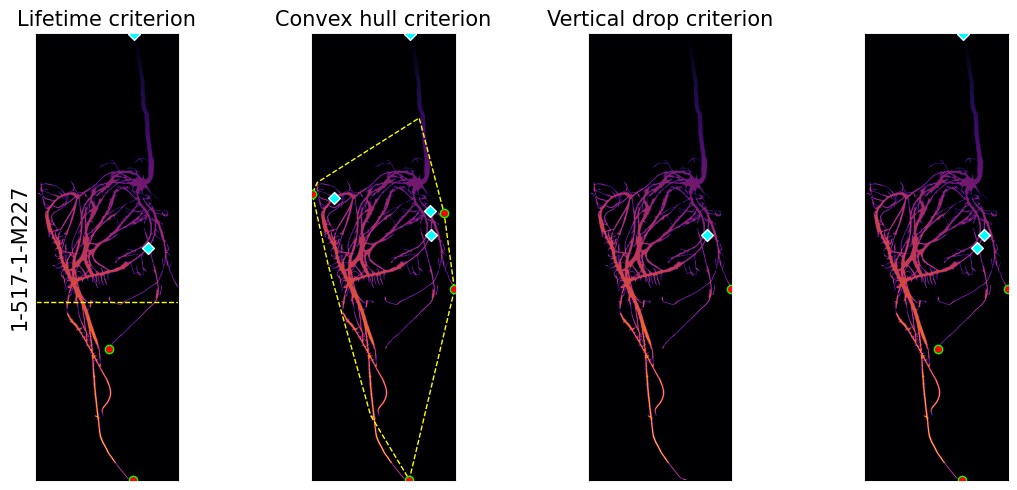

In [131]:
tmask = lmask.copy()
tmask |= vmask
#tmask |= chmask 

fs = 15
ss = np.s_[1500:2000, 0:500]
extent = (ss[1].start, ss[1].stop, ss[0].stop, ss[0].start)

fig, ax = plt.subplots(1,4, figsize=(12,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

for i,mask in enumerate([lmask, chmask, vmask, tmask]):
    ax[i].imshow(gdt, cmap='inferno', origin='upper', vmin=0)
    ax[i].scatter(tips[mask,1], tips[mask,0], marker='o', color='r', edgecolor='lime', linewidth=1, zorder=3)
    ax[i].scatter(merge[mask,1], merge[mask,0], marker='D', color='cyan', edgecolor='w', linewidth=1, zorder=3)
    ax[i].tick_params(labelleft=False, left=False, bottom=False, labelbottom=False)
    #ax[i].set_xlim(extent[0],extent[1]); ax[i].set_ylim(extent[2],extent[3])

ax[0].set_ylabel(bname, fontsize=fs)
ax[0].axhline(np.quantile(tips[:,0], 0.875), c='yellow', ls='--', lw=1)
ax[1].plot(*thull, c='yellow', lw=1, ls='--', zorder=2)

i = 0
ax[i].set_title('Lifetime criterion', fontsize=fs); i+=1
ax[i].set_title('Convex hull criterion', fontsize=fs); i+=1
ax[i].set_title('Vertical drop criterion', fontsize=fs); i+=1

fig.tight_layout()

filename = ddst + 'main_root_tip_-_' + bname
#plt.savefig(filename +'.png', format='png', bbox_inches='tight', dpi=200)

In [132]:
filename = gdst + bname + '_-_root_tips.csv'
print(filename)
np.savetxt(filename, np.nonzero(tmask)[0].reshape(1,-1), delimiter=',', fmt='%d')

../run02/gudhi/1-517-1-M227_-_root_tips.csv


# Make a proper geodesic watershed

Iteration:	 2 

Found 8 connected components
Main labels:	 [0 6 7] 
Minor labels:	 [1 2 3 4 5] 
--

Iteration:	 1 

Found 7 connected components
Main labels:	 [0 5] 
Minor labels:	 [1 2 3 4 6] 
--

Iteration:	 0 

Found 1 connected components
Main labels:	 [0] 
Minor labels:	 [] 
--



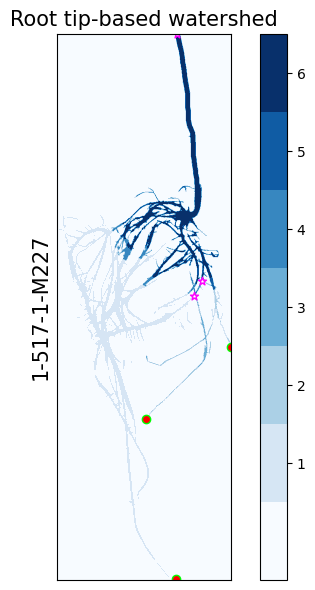

In [133]:
watershed = np.zeros(inv.shape, dtype=np.uint8)
colorval = 1
colordict = dict()

#fig, ax = plt.subplots(1,len(rest[tmask]), figsize=(12,5), sharex=True, sharey=True)
#ax = np.atleast_1d(ax).ravel(); k = 0

for ix in range(len(rest[tmask])-1, -1, -1):
    print('Iteration:\t', ix, '\n')
    thr = main[rest[tmask][ix,1]]
    timg = gimg*(inv < thr)
    
    label, nums = ndimage.label( timg, structure=ndimage.generate_binary_structure(2,1))
    print('Found',nums,'connected components')
    hist, bins = np.histogram(label, bins=range(1,nums+2))
    hargsort = np.argsort(hist)[::-1]
    mainlabels = np.zeros(ix+1, dtype=int)
    for i in range(len(mainlabels)):
        foo = label[tuple(tips[tmask][i])]
        mainlabels[i] = foo-1
    mainlabels = mainlabels[mainlabels > -1]
    minorlabels = np.setdiff1d(range(nums), mainlabels)
    print('Main labels:\t',mainlabels,'\nMinor labels:\t',minorlabels,'\n--\n')
    
    foo = timg*inv
    ends = np.asarray(ndimage.maximum_position(foo, label, index=range(1,nums+1)))
    sdist = spatial.distance_matrix(ends[mainlabels], ends[minorlabels])

    for i in range(len(mainlabels)):
        mask = (watershed == 0) & (label == mainlabels[i] + 1)
        watershed[mask] = colorval
        extras = np.nonzero(mainlabels[np.argmin(sdist, axis=0)] == mainlabels[i])[0]
        for j in minorlabels[extras]:
            mask = (watershed == 0) & (label == j+1)
            watershed[mask] = colorval
        
        colorlist = []
        for j in range(len(tips[tmask])):
            if label[tuple(tips[tmask][j])] == mainlabels[i] + 1:
                colorlist.append(rest[tmask][j,0])
        colordict[colorval] = colorlist
        colorval += 1

fs = 15
cmap = plt.get_cmap('Blues', len(colordict) + 1)

fig, ax = plt.subplots(1,1, figsize=(6,6), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

a = ax[0].imshow(watershed, cmap=cmap, origin='upper', vmin=-.5, vmax=len(colordict)+.5)
ax[0].scatter(tips[tmask,1], tips[tmask,0], marker='o', color='r', edgecolor='lime', linewidth=1)
ax[0].scatter(merge[tmask,1], merge[tmask,0], marker='*', color='white', edgecolor='magenta', linewidth=1)
ax[0].tick_params(labelleft=False, left=False, bottom=False, labelbottom=False)
ax[0].set_ylabel(bname, fontsize=fs)
ax[0].set_title('Root tip-based watershed', fontsize=fs)
cax = plt.colorbar(a, ticks=range(1, len(colordict) + 1))

fig.tight_layout()

filename = ddst + 'watershed_root_tip_-_' + bname
plt.savefig(filename +'.png', format='png', bbox_inches='tight', dpi=200)

In [109]:
if False:
    watershed = np.zeros(inv.shape, dtype=np.uint8)
    colorval = 1
    colordict = dict()
    
    #fig, ax = plt.subplots(1,1, figsize=(7,7), sharex=True, sharey=True)
    #ax = np.atleast_1d(ax).ravel(); k = 0
    
    ix = np.sum(tmask)-1
    print('Iteration:\t', ix, '\n')
    thr = main[rest[tmask][ix,1]]
    timg = gimg*(inv < thr)
    
    label, nums = ndimage.label( timg, structure=ndimage.generate_binary_structure(2,1))
    print('Found',nums,'connected components')
    hist, bins = np.histogram(label, bins=range(1,nums+2))
    hargsort = np.argsort(hist)[::-1]
    mainlabels = np.zeros(ix+1, dtype=int)
    for i in range(len(mainlabels)):
        foo = label[tuple(tips[tmask][i])]
        mainlabels[i] = foo-1
    mainlabels = mainlabels[mainlabels > -1]
    minorlabels = np.setdiff1d(range(nums), mainlabels)
    print('Main labels:\t',mainlabels,'\nMinor labels:\t',minorlabels)
    
    if False:
        foo = timg*inv
        ends = np.asarray(ndimage.maximum_position(foo, label, index=range(1,nums+1)))
        sdist = spatial.distance_matrix(ends[mainlabels], ends[minorlabels])
        
        for i in range(len(mainlabels)):
            mask = (watershed == 0) & (label == mainlabels[i] + 1)
            watershed[mask] = colorval
            extras = np.nonzero(mainlabels[np.argmin(sdist, axis=0)] == mainlabels[i])[0]
            for j in minorlabels[extras]:
                mask = (watershed == 0) & (label == j+1)
                watershed[mask] = colorval
            
            colorlist = []
            for j in range(len(tips[tmask])):
                if label[tuple(tips[tmask][j])] == mainlabels[i] + 1:
                    colorlist.append(rest[tmask][j,0])
            colordict[colorval] = colorlist
            colorval += 1
        
        #ax[k].imshow(watershed, cmap='Blues', origin='upper', vmin=0, vmax=len(colordict)); k+=1

Iteration:	 2 

Found 11 connected components
Main labels:	 [5 2] 
Minor labels:	 [ 0  1  3  4  6  7  8  9 10]


In [96]:
print(len(colordict))
colordict

21


{1: [6802501],
 2: [19559319],
 3: [12891608],
 4: [10093177],
 5: [6802501, 10093177],
 6: [2796044],
 7: [19559319],
 8: [12891608],
 9: [6802501, 12891608, 10093177],
 10: [2796044],
 11: [19559319],
 12: [6802501, 19559319, 12891608, 10093177],
 13: [13044],
 14: [19029204],
 15: [2796044],
 16: [6802501, 2796044, 19559319, 12891608, 10093177],
 17: [13044],
 18: [19029204],
 19: [6802501, 19029204, 2796044, 19559319, 12891608, 10093177],
 20: [13044],
 21: [6802501, 13044, 19029204, 2796044, 19559319, 12891608, 10093177]}

```
Found 8 connected components
[70.7 16.4 12.4  0.3  0.2  0.1  0.   0. ]
[558372 129166  97834   2186   1752    637      1      1]
```

In [ ]:
fig, ax = plt.subplots(1,signif0.size-1, figsize=(12,6), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i, thr in enumerate(np.sort(signif0.ravel())[1:]):
    ax[i].imshow(gimg*(inv < thr), vmin = 0, vmax = 1, cmap='inferno', origin='upper')
    ax[i].set_title(np.round(thr,1), fontsize=14)
    #ax[i].scatter(tipy[tmask,0], tipx[tmask,0], marker='o', color='r', edgecolor='cyan', linewidth=1)
    #ax[i].scatter(tipy[tmask,1], tipx[tmask,1], marker='D', color='cyan', edgecolor='r', linewidth=1)
    ax[i].scatter(ends[mainlabels,1], ends[mainlabels,0], marker='D', color='cyan', edgecolor='r', linewidth=1, zorder=2)
    ax[i].scatter(ends[minorlabels,1], ends[minorlabels,0], marker='o', color='r', edgecolor='cyan', linewidth=1, zorder=3)

fig.tight_layout();

In [ ]:
wshds = np.zeros((len(tips[tmask]), gimg.shape[0], gimg.shape[1]))

for i in range(len(wshds)):
    m = np.copy(gimg)
    m[tuple(tips[tmask][i])] = False
    m = np.ma.masked_array(m, ~gimg)
    wshds[i] = skfmm.distance(m).data

watershed = np.min(wshds, axis=0)
argwatershed = np.argmin(wshds, axis=0)
argwatershed[gimg] += 1

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,7), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i,im in enumerate([watershed, argwatershed]):
    ax[i].imshow(im, cmap='inferno', origin='upper', vmin=0)
    #ax[i].scatter(foo[1], foo[0], marker='.', color='r', alpha=0.1)
    #ax[i].set_xlim(extent[0],extent[1]); ax[i].set_ylim(extent[2],extent[3])
    #ax[i].axvline(ix[1] + .5, c='r'); ax[i].axhline(ix[0] + .5, c='r')

#fig.delaxes(ax[-1])
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(1,len(wshds), figsize=(12,6), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i in range(len(ax)):
    
    ax[i].imshow(wshds[i], vmin = 0, cmap='inferno', origin='upper')
    ax[i].scatter(tips[tmask,1], tips[tmask,0], marker='o', color='r', edgecolor='lime', linewidth=1)
    ax[i].scatter(merge[tmask,1], merge[tmask,0], marker='D', color='cyan', edgecolor='white', linewidth=1)

fig.tight_layout();